<h1 style="text-align: center;"><span style="color: #333399;">MIS670 Classification Modeling HW: Various ML Applications</span></h1>
<h6 style="text-align: center;">Created by: Michael Gagliano on 10/18/2018</h6>
<h6 style="text-align: center;">"K-State Honor Code "On my honor, as a student, I have neither given nor received unauthorized aid on this academic work.</h6>

In [175]:
%matplotlib inline
import nltk
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sklearn
import numpy as np
import requests as req #Pulls the data via URL
from lxml import html #Xpath manipulation
import re #Regular Expression to target specific parent:child nodes 
from collections import Counter

# feature engineering (words to vectors)
from sklearn.feature_extraction.text import TfidfVectorizer

# classification algorithms (or classifiers)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# build a pipeline
from sklearn.pipeline import Pipeline

# model evaluation, validation
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#pip install scikit-plot 
import scikitplot as skplt

#Stopwords
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

<h1 style="text-align: center;">1. Data Extraction and Pre-Processing </span>

## Scraping and Importing HR Recruiting Data (650 Items)

In [126]:
web = "https://www.workforce.com/topics/Recruitment/page/%s" #20 reviews per page == 10 pages

alldata =[]

for page in range(1, 65):
    url = web % page
    data = html.fromstring(req.get(url).text)
#xpath
    for i in data.xpath('//article'):
        rev = i.xpath('div/div[@class="tm-article-content"]/text() | div/div[@class="tm-article-content"]/p/text()')
        alldata.append([rev])      
    
len(alldata)

614

<b>There are only 614 Total Reviews to pull from this website regarding recruitment articles

In [188]:
df = pd.DataFrame(alldata)
df.to_csv('hr_data_test.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 1 columns):
0    614 non-null object
dtypes: object(1)
memory usage: 4.9+ KB


In [189]:
df.head()

,0
0,"[SSM Health, Choptank Transport Inc. and ReedT..."
1,"[AMB Group, LLC hired and trained 4,000 new em..."
2,[Sporting events during the work week can be a...
3,[Gen Z is changing the workplace with their li...
4,[The acquisition of Glint complements LinkedIn...


In [190]:
df['is_hr'] = 1 #add column indicating classification
df.rename(columns = {0 : 'review', 1: 'is_hr'}, inplace = True) #change column names
df['review'] = df['review'].apply(', '.join) #remove brackets
df.head()

,review,is_hr
0,"SSM Health, Choptank Transport Inc. and ReedTM...",1
1,"AMB Group, LLC hired and trained 4,000 new emp...",1
2,Sporting events during the work week can be a ...,1
3,Gen Z is changing the workplace with their lif...,1
4,The acquisition of Glint complements LinkedIn’...,1


## Importing Movie Review Data (150 items)

In [191]:
df2 = pd.read_csv('rev.csv', header = None )
df2.rename(columns = {0 : 'review'}, inplace = True)
df2['is_hr'] = 0
df2.head()

,review,is_hr
0,I have never seen such an amazing film since I...,0
1,Tell me a movie that is more famous than this....,0
2,The original Godfather is a brilliant work. It...,0
3,"I couldn't believe ""The Dark knight"" could liv...",0
4,Spielberg is now the Numero Uno director of sc...,0


## Merging Dataframes to a single Train Dataset

In [192]:
dataframes = [df, df2]
hr = pd.concat(dataframes).reset_index(drop = True)
hr[610:620] #Confirmed that the concatenation worked between dataframes

,review,is_hr
610,You don’t need an HR drone; you need stellar t...,1
611,One 31-question survey used by Ceridian for it...,1
612,It looks like nothing was found at this locati...,1
613,It looks like nothing was found at this locati...,1
614,I have never seen such an amazing film since I...,0
615,Tell me a movie that is more famous than this....,0
616,The original Godfather is a brilliant work. It...,0
617,"I couldn't believe ""The Dark knight"" could liv...",0
618,Spielberg is now the Numero Uno director of sc...,0
619,Saying that this film starts where `Two Towers...,0


In [193]:
hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764 entries, 0 to 763
Data columns (total 2 columns):
review    764 non-null object
is_hr     764 non-null int64
dtypes: int64(1), object(1)
memory usage: 12.0+ KB


In [194]:
hr['review'] = hr['review'].str.lower() #change case all to lower
hr['review'] = hr['review'].str.replace('[^a-zA-Z]+', ' ') #replace all non alphanumerics
hr['review'] = hr['review'].str.findall('\w{3,}').str.join(' ') #"replace" or only show words >3 char

In [195]:
hr.head()

,review,is_hr
0,ssm health choptank transport inc and reedtms ...,1
1,amb group llc hired and trained new employees ...,1
2,sporting events during the work week can distr...,1
3,gen changing the workplace with their lifestyl...,1
4,the acquisition glint complements linkedin str...,1


In [196]:
hr['review'] = hr['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

<b> I have decided not to remove any extra StopWords to prevent bias within the model. I want it to classify without missing specific words that are important to the context of each datapoint which ultimately will determine classification. This treats the Train dataset as a single entity rather than two merged datasets with their own bias.

In [197]:
#Save to CSV
hr.to_csv('hr.csv', header = None)

In [198]:
hr.head()

,review,is_hr
0,ssm health choptank transport inc reedtms logi...,1
1,amb group llc hired trained new employees four...,1
2,sporting events work week distraction employee...,1
3,gen changing workplace lifestyle ambitions acc...,1
4,acquisition glint complements linkedin strateg...,1


<h1 style="text-align: center;">2. Vectorization of the Dataset, TFID, and Document-Term Matrix Conversion</span>

In [205]:
hr_data = []
hr_labels = []
hr = []

openfile = open('hr.csv', 'rt')
r = csv.reader(openfile)
for i in r:
    hr.append(i)
    hr_data.append(i[1])
    hr_labels.append(i[2])    
openfile.close()

In [212]:
tfidf_vectorizer = TfidfVectorizer(decode_error ='ignore')
tfidf = tfidf_vectorizer.fit_transform(hr_data)
print(tfidf.shape)
print(tfidf)

(764, 8638)
  (0, 7247)	0.30228614548604044
  (0, 3522)	0.20916139800591743
  (0, 1252)	0.30228614548604044
  (0, 7943)	0.30228614548604044
  (0, 3823)	0.2281042167611992
  (0, 6226)	0.30228614548604044
  (0, 4512)	0.30228614548604044
  (0, 6178)	0.24777230050146049
  (0, 7873)	0.1630962309757716
  (0, 7797)	0.18744785141924258
  (0, 541)	0.49554460100292097
  (0, 6212)	0.14176495529641156
  (0, 5306)	0.2419616964038225
  (1, 264)	0.3153082098489462
  (1, 3388)	0.2155773893871147
  (1, 4493)	0.2737182752496491
  (1, 3597)	0.23034813395586068
  (1, 7924)	0.26544279961803047
  (1, 5112)	0.2957439825894478
  (1, 2452)	0.1514106229737258
  (1, 3084)	0.22698441367806663
  (1, 4940)	0.23398122862929915
  (1, 5282)	0.23034813395586068
  (1, 7226)	0.3153082098489462
  (1, 7251)	0.3153082098489462
  :	:
  (763, 6835)	0.1200716992651233
  (763, 4990)	0.3295801586558013
  (763, 3118)	0.11148905027317124
  (763, 1892)	0.13042477501932664
  (763, 3158)	0.09786681490605147
  (763, 4785)	0.1246682198

In [218]:
#previewing first 5 vectorized feature names
tfidf_vectorizer.get_feature_names()[:5]

['aah', 'aaron', 'abandon', 'abandoned', 'abducted']

In [219]:
#Creating a a matrix from the data
tfidf_matrix = tfidf_vectorizer.fit_transform(hr_data).toarray()
tfidf_matrix 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [220]:
pd.DataFrame(tfidf_matrix,index=hr_data,columns=tfidf_vectorizer.get_feature_names()).head()

,aah,aaron,abandon,abandoned,abducted,abhorrent,abide,abiding,abilities,ability,...,zany,zealand,zemeckis,zero,zimmer,ziprecruiter,zoombezi,zooming,zooms,zucker
ssm health choptank transport inc reedtms logistics received top three awards recruiting optimas awards,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amb group llc hired trained new employees four months open new sports stadium incorporating community around,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sporting events work week distraction employees nonetheless employers finding great employee engagement retention tool,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gen changing workplace lifestyle ambitions according recent indeed report job interests fall one category,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acquisition glint complements linkedin strategy acquiring tools necessary help rapidly execute long term strategies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b>All items within the data have now been vectorized/scored. There are 8638 features within the dataset!</b>

<h1 style="text-align: center;">3. Building the Model via Feature Extraction Methods</span>

## a. Training the Model via Split Validation (80/20 Split)

In [223]:
##-- Test Size is being set to 0.2, or an 80/20 split of Train Data/Test Data

x_train, x_test, y_train, y_test = train_test_split(hr_data, hr_labels, test_size=0.2, random_state=0)
len(x_train), len(y_train), len(x_test), len(y_test)

(611, 611, 153, 153)

In [225]:
X_train = tfidf_vectorizer.fit_transform(x_train)
X_test = tfidf_vectorizer.transform(x_test)
print(X_train[:2])
print("+++++++++++++++++++++++++++++++++++++++++")
print(X_test[:2])

  (0, 4120)	0.22515029224338887
  (0, 4016)	0.3322699043872912
  (0, 6995)	0.2877105134082167
  (0, 3960)	0.3054055869427547
  (0, 6383)	0.2442354906579922
  (0, 4404)	0.3054055869427547
  (0, 5065)	0.3054055869427547
  (0, 7100)	0.22515029224338887
  (0, 3327)	0.2476295712181226
  (0, 2655)	0.2476295712181226
  (0, 3553)	0.24104724204699896
  (0, 7004)	0.22748801025343743
  (0, 5225)	0.22515029224338887
  (0, 7526)	0.2877105134082167
  (1, 2655)	0.2711954279087576
  (1, 1116)	0.31509070348008344
  (1, 2672)	0.2945480946622825
  (1, 4767)	0.387243289582818
  (1, 7467)	0.2417745472400655
  (1, 2705)	0.2840473278326562
  (1, 5945)	0.3006163085774498
  (1, 2365)	0.21328263449886375
  (1, 4459)	0.2794372870647308
  (1, 2671)	0.36389062282929313
  (1, 3958)	0.32396897533097463
+++++++++++++++++++++++++++++++++++++++++
  (0, 7840)	0.04832676210939189
  (0, 7838)	0.06665543265036462
  (0, 7792)	0.13101305901294738
  (0, 7780)	0.07884410654148483
  (0, 7754)	0.04596609208113755
  (0, 7713)	0.0

### i. Naive-Bayes Classifier Pipeline

In [233]:
# removing stopwords & rare words
# min_df=2 argument removes words that appear in 2 or less documents/items

nb_pipeline = Pipeline([('tfidf',
                         TfidfVectorizer(decode_error ='ignore', stop_words='english', min_df=2)),
                        ('clf', MultinomialNB())])
nb_pipeline = nb_pipeline.fit(x_train, y_train)
predicted = nb_pipeline.predict(x_test)
np.mean(predicted == y_test)  

1.0

In [234]:
print('\n overall accuracy:')
print(metrics.accuracy_score(y_test, predicted))

print('\n confusion_matrix:')
print(metrics.confusion_matrix(y_test, predicted))

print('\n Here is the classification report:')
print(metrics.classification_report(y_test, predicted))


 overall accuracy:
1.0

 confusion_matrix:
[[ 28   0]
 [  0 125]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        28
          1       1.00      1.00      1.00       125

avg / total       1.00      1.00      1.00       153



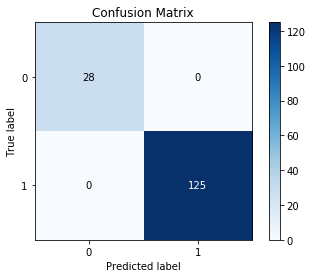

In [235]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predicted)
plt.show()

<b> The Naive Bayes Classifier has overfit the data, most likely, with a 100% accuracy rate. The best option would be to add additional data to diversify the algorithm. I believe the length and diversity of the HR News Articles vs. that of the movie review data that was merged may play a large part of it

### ii. K-NN Classifier Pipeline

In [241]:
from sklearn.neighbors import KNeighborsClassifier #import algorithm

#Include completed pipeline
knn_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore')), ('clf', KNeighborsClassifier())])
knn_pipeline = knn_pipeline.fit(x_train, y_train)
predicted = knn_pipeline.predict(x_test)
np.mean(predicted == y_test)  

0.9869281045751634

In [242]:
print('\n overall accuracy:')
print(metrics.accuracy_score(y_test, predicted))

print('\n confusion_matrix:')
print(metrics.confusion_matrix(y_test, predicted))

print('\n Here is the classification report:')
print(metrics.classification_report(y_test, predicted))


 overall accuracy:
0.9869281045751634

 confusion_matrix:
[[ 28   0]
 [  2 123]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       0.93      1.00      0.97        28
          1       1.00      0.98      0.99       125

avg / total       0.99      0.99      0.99       153



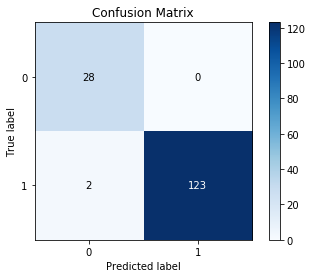

In [243]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predicted)
plt.show()

<b>Only 2 False Negatives (Incorrectly classified HR Recruiting News as Non-HR related) which is great. While this technically has the lowest accuracy, at 99% I find the slight error more human and potentially revealing of a more "true" accuracy 

### Support Vector Machine (SVM) Classifier

In [244]:
svm_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore')), ('clf', SVC(kernel='linear', probability=True))])
svm_pipeline = svm_pipeline.fit(x_train, y_train)
predicted = svm_pipeline.predict(x_test)
np.mean(predicted == y_test)

1.0

In [245]:
print('\n overall accuracy:')
print(metrics.accuracy_score(y_test, predicted))

print('\n confusion_matrix:')
print(metrics.confusion_matrix(y_test, predicted))

print('\n Here is the classification report:')
print(metrics.classification_report(y_test, predicted))


 overall accuracy:
1.0

 confusion_matrix:
[[ 28   0]
 [  0 125]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        28
          1       1.00      1.00      1.00       125

avg / total       1.00      1.00      1.00       153



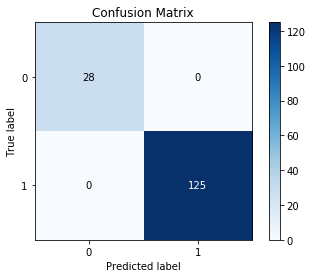

In [246]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predicted)
plt.show()

<b> Again, the SVM Classifier has overfit the data, most likely. The best option would be to add additional data to diversify the algorithm. I believe the length and diversity of the HR News Articles vs. that of the movie review data that was merged may play a large part of it

<span style="color: red"><b>As a result of the high accuracies shared between models based on the Split Validation performed amongst each - I am going to select K-NN as my method to hopefully prevent complete overfitting</b></span>

<h1 style="text-align: center;"> 4. Deploying K-NN Classification Model with new data </span>

In [247]:
#acquired from Top Headlines page of CNN

new_data = ['Women are more faithful than men, and other myths on female infidelity',
                'Veteran battling suicidal thoughts opens horse ranch to help military families',
                'Ten vegan versions of tailgate classics',
                '155 cases of polio-like illness now under investigation, CDC says',
                'You can cut your cancer risk by eating organic, a new study says',
                'Marlboro maker attacked for hypocritical anti-smoking campaign',
                'Deadly violence in DRC hampers Ebola control',
                'Report says the UNs global war on drugs has been a failure',
                'USC says its tentatively agreed to $215M settlement over gynecologist misconduct claims']

In [250]:
knn1 = KNeighborsClassifier().fit(X_train, y_train)
predicted = knn1.predict(X_test)
np.mean(predicted == y_test)


0.9869281045751634

<b>98.7% Accuracy for new data introduced using Trained KNN Classifier

In [252]:
# Assigning/Showing Classifier Labels

new_tfidf = tfidf_vectorizer.transform(new_data)

predicted = knn1.predict(new_tfidf)

for doc, category in zip(new_data, predicted):
    print('%r => %s' % (doc, category))

'Women are more faithful than men, and other myths on female infidelity' => 1
'Veteran battling suicidal thoughts opens horse ranch to help military families' => 1
'Ten vegan versions of tailgate classics' => 0
'155 cases of polio-like illness now under investigation, CDC says' => 1
'You can cut your cancer risk by eating organic, a new study says' => 1
'Marlboro maker attacked for hypocritical anti-smoking campaign' => 1
'Deadly violence in DRC hampers Ebola control' => 0
'Report says the UNs global war on drugs has been a failure' => 1
'USC says its tentatively agreed to $215M settlement over gynecologist misconduct claims' => 1


In [254]:
# Predicted Probability Per Feature

predicted_prob = knn1.predict_proba(new_tfidf)

for doc, category in zip(new_data, predicted_prob):
    print('%r => %s' % (doc, category))

'Women are more faithful than men, and other myths on female infidelity' => [0. 1.]
'Veteran battling suicidal thoughts opens horse ranch to help military families' => [0. 1.]
'Ten vegan versions of tailgate classics' => [0.8 0.2]
'155 cases of polio-like illness now under investigation, CDC says' => [0. 1.]
'You can cut your cancer risk by eating organic, a new study says' => [0. 1.]
'Marlboro maker attacked for hypocritical anti-smoking campaign' => [0.2 0.8]
'Deadly violence in DRC hampers Ebola control' => [0.8 0.2]
'Report says the UNs global war on drugs has been a failure' => [0. 1.]
'USC says its tentatively agreed to $215M settlement over gynecologist misconduct claims' => [0. 1.]


<h1 style="text-align: center;"> 5. Summary </span>

- We gathered just over 700 data points for a initial Training Dataset, used to classify HR Recruiting Content vs. Non-HR Content
<br><br>
- We Performed Split Validation using an 80/20 split 
<br><br>
- From the Split Validation, we built 3 Machine Learning Pipelines using 3 various models: Naive Bayes, K-NearestNeighbor, and Support Vector Machine
<br><br>
- All models were incredibly accurate between 99% and 100% - I believe this is a result of overfitting. This can be prevented or remedied by adding additional data to the training set that also diversifies it.
<br><br>
- Using K-NN, I applied this model to new data to predict/classify it accordingly. The applied model had a 98.7% accuracy rating which is great! That means 98.7% of collected data will be correctly classified as either HR News or Non-HR news.


<h1 style="text-align: center;"> 6. Neural Network Model Application </span>

In [258]:
from sklearn.neural_network import MLPClassifier #Importing NN Multi-Layer Perceptron Classifier

#Set L2 Penalizer (alpha) to 0.05 to be a bit more aggressive on feature regularization
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.05) 
mlp.fit(X_train,y_train)

predictions = mlp.predict(X_test)
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[ 26   2]
 [  0 125]]
             precision    recall  f1-score   support

          0       1.00      0.93      0.96        28
          1       0.98      1.00      0.99       125

avg / total       0.99      0.99      0.99       153



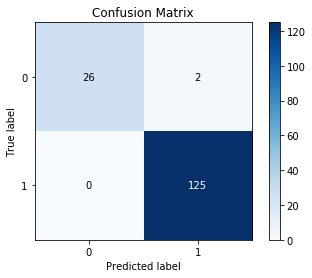

In [260]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predictions)
plt.show()

99% Accurate of a model, where only 2/26 'True' Labels were False Positives 